<a href="https://colab.research.google.com/github/Manjil-Munankarmi/ConvNeXtVsResNet/blob/main/Grad_CAM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Grad-CAM - training tutorial


In this Colab notebook, we show how to train (fine-tune) a pre-trained model on a dataset of cats and dogs. We will then show you how to use Grad-CAM to interpret the neural network.




And a sample of cat & dog images that were not used in model training

In [ ]:
!gdown --id 1-3360B0mciNsg-tLaj482APOR9IPYVUT
!unzip val_1000.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-3360B0mciNsg-tLaj482APOR9IPYVUT
To: /content/val_1000.zip
100% 22.6M/22.6M [00:00<00:00, 30.8MB/s]
Archive:  val_1000.zip
   creating: val_1000/
  inflating: val_1000/cat_705.jpg    
  inflating: val_1000/cat_947.jpg    
  inflating: val_1000/dog_87.jpg     
  inflating: val_1000/dog_186.jpg    
  inflating: val_1000/dog_764.jpg    
  inflating: val_1000/cat_104.jpg    
  inflating: val_1000/cat_429.jpg    
  inflating: val_1000/dog_302.jpg    
  inflating: val_1000/dog_807.jpg    
  inflating: val_1000/cat_616.jpg    
  inflating: val_1000/dog_46.jpg     
  inflating: val_1000/cat_35.jpg     
  inflating: val_1000/cat_647.jpg    
  inflating: val_1000/cat_551.jpg    
  inflating: val_1000/cat_746.jpg    
  inflatin

# Data Processing


We've included helper functions that will label images, convert them into arrays, and then finally into a generator that wil enable them to be loaded into the model in batches

In [ ]:
import random
from random import shuffle
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.utils.data_utils import Sequence


In [ ]:
def label_image_one_hot_encoder(img):
  ## Helper for process_data
  label = img.split('_')[0]
  if label == 'cat': return 0
  elif label == 'dog': return 1


def process_data(image_list, DATA_FOLDER, IMG_SIZE):
  ## Helper for manual_pre_process
  ## Creates an array of images, labels, and file path
  ## Shuffles the array before returning
  data_df = []
  for img in tqdm(image_list):
    path = os.path.join(DATA_FOLDER, img)
    label = label_image_one_hot_encoder(img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    data_df.append([np.array(img), np.array(label), path])
  shuffle(data_df)
  return data_df


def manual_pre_process(dir, IMG_SIZE):
  '''
  Creates an array of images, labels, and files from a directory of image files

  Args:
    dir: string, folder name
    IMG_SIZE: int, image height and width

  Returns
    X: (n x IMG_SIZE x IMG_SIZE) numpy array of images
    y: (n,) numpy array of labels
    files: (n,) numpy array of files

  '''
  image_lst = os.listdir(dir)
  data_df = process_data(image_lst, dir, IMG_SIZE)
  X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  y = np.array([i[1] for i in data_df])
  files = np.array([i[2] for i in data_df])
  return X, y, files



In [ ]:
val_imgs = 'val_1000'
class_info = {0: 'Cat', 1: 'Dog'}

X, y, files = manual_pre_process(val_imgs, 224)

100%|██████████| 1000/1000 [00:01<00:00, 604.47it/s]


# Loading the Pre-Trained Model
We will be using a MobileNetV2 (you can read about the architecture here https://arxiv.org/abs/1801.04381) model which provides a good tradeoff between accuracy and efficiency.

The model was trained with custom evaluation metrics, precision and recall.

In [ ]:
import tensorflow as tf
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
import keras
model_builder = keras.applications.convnext.ConvNeXtTiny

In [ ]:
model = tf.keras.models.load_model('mobilenetv2_epochs25_batch25_sample_size2000_aug_0.h5', custom_objects={"precision_m": precision, "recall_m": recall})

In [ ]:
model = model_builder(weights="imagenet")


114735104/114735104 [==============================] - 2s 0us/step


# Interpreting the Results with Grad-CAM

Lets start by looking at a Grad-CAM heatmap of a singular image from the validation image set

In [ ]:
preprocess_input = keras.applications.convnext.preprocess_input
decode_predictions = keras.applications.convnext.decode_predictions



def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

img_size = (224, 224)
img = X[59]
array = keras.utils.img_to_array(img)
img_array = preprocess_input(np.expand_dims(array, axis=0))


# Print what the top predicted class is
preds = model.predict(img_array)
pred_decoded = decode_predictions(preds, top=1)[0]
print(pred_decoded)
print("Predicted:", decode_predictions(preds, top=1)[0])

1/1 [==============================] - 3s 3s/step
[('n02124075', 'Egyptian_cat', 0.9368922)]
Predicted: [('n02124075', 'Egyptian_cat', 0.9368922)]


In [ ]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
  pred = tf.where(pred < 0.5, 0, 1)
  return pred.numpy()


0

1/1 [==============================] - 3s 3s/step
1.0647968e-05
0


Text(0.5, 1.0, 'Cat 1.0647968e-05')

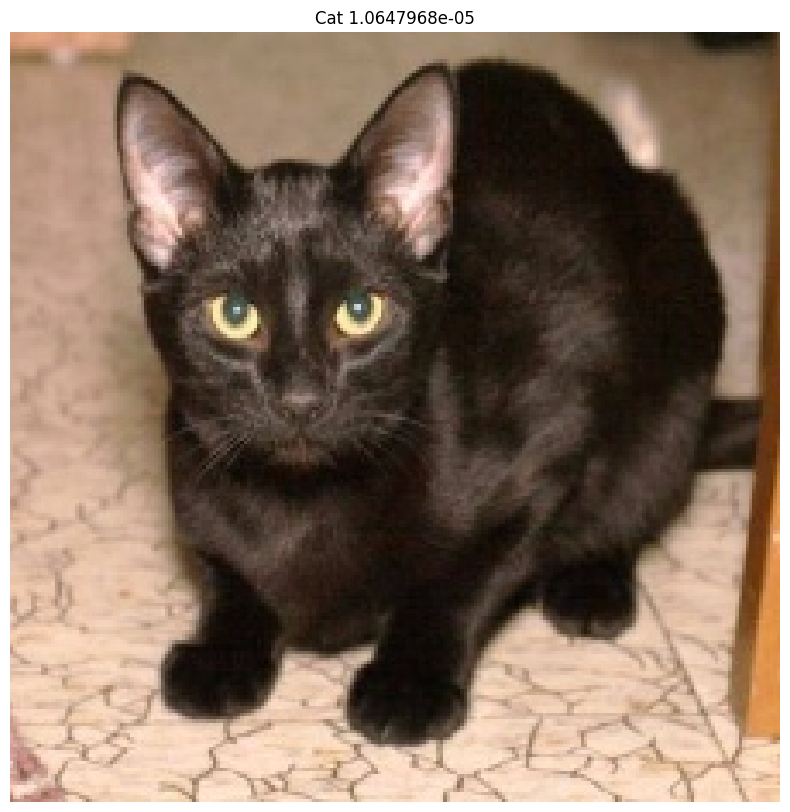

In [ ]:

img = X[59]
label = y[59]
path = files[59]

pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]
print(pred_raw)
pred = decode_prediction(pred_raw)
print(pred)
pred_label = class_info[pred]

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(pred_label + ' ' + str(pred_raw))

In [ ]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model


    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])

    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):

    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.


    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb

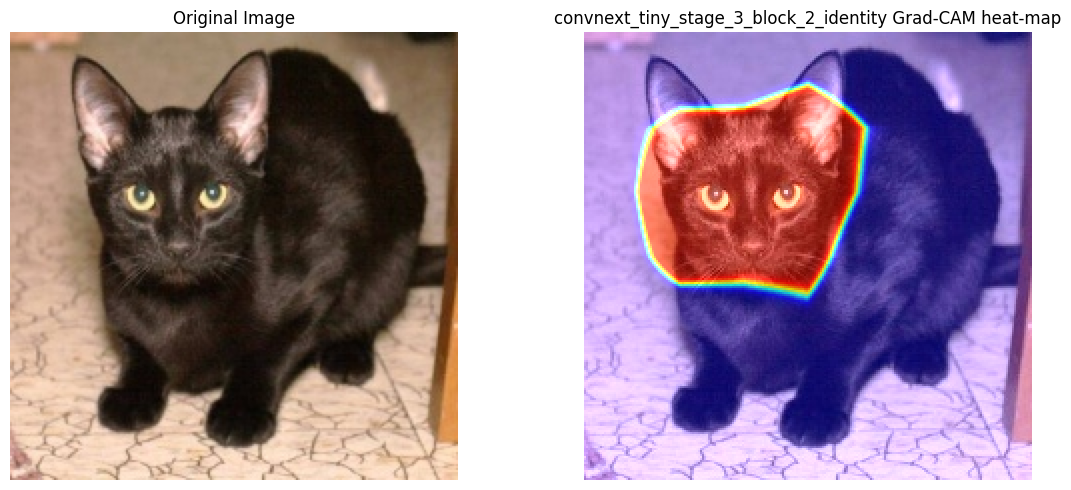

In [ ]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1

layer_name = 'convnext_tiny_stage_3_block_2_identity'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('convnext_tiny_stage_3_block_2_identity Grad-CAM heat-map')
plt.tight_layout()




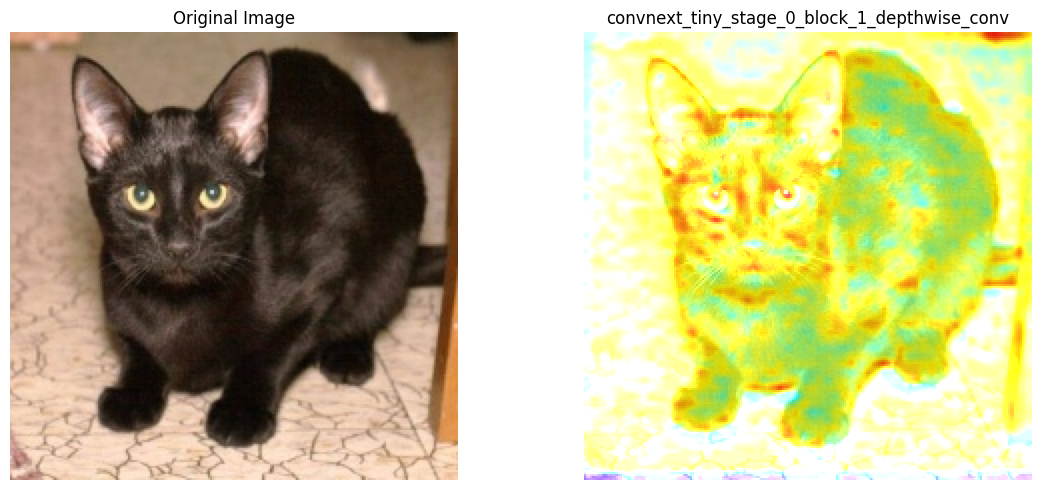

In [ ]:
## Grad-CAM heatmap for the block_4_expand_relu
## This layer shows how the model begins learning concepts in the image

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
grad_cam = GradCam(model, np.expand_dims(img, axis=0), 'convnext_tiny_stage_0_block_1_depthwise_conv')
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title('convnext_tiny_stage_0_block_1_depthwise_conv')
plt.tight_layout()


In [ ]:
print(model.layers)

[<keras.src.engine.input_layer.InputLayer object at 0x7b915ff93ee0>, <keras.src.layers.preprocessing.normalization.Normalization object at 0x7b9160000d30>, <keras.src.engine.sequential.Sequential object at 0x7b91600026e0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b915cd1d3f0>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7b915cd1d6f0>, <keras.src.layers.core.dense.Dense object at 0x7b915cd1fa30>, <keras.src.layers.core.activation.Activation object at 0x7b915cd69f60>, <keras.src.layers.core.dense.Dense object at 0x7b915cd1f640>, <keras.src.applications.convnext.LayerScale object at 0x7b915cd1f3a0>, <keras.src.layers.core.activation.Activation object at 0x7b915cd6ab60>, <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x7b915cd68400>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b915cd1d180>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7b915cd1e1d0>, <keras.src.layers.core.

In [ ]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'GeLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'GeLU' or isinstance(layer, tf.keras.layers.Conv2D))]


In [ ]:
conv2D_layers

['convnext_tiny_stage_3_block_2_depthwise_conv',
 'convnext_tiny_stage_3_block_1_depthwise_conv',
 'convnext_tiny_stage_3_block_0_depthwise_conv',
 'convnext_tiny_stage_2_block_8_depthwise_conv',
 'convnext_tiny_stage_2_block_7_depthwise_conv',
 'convnext_tiny_stage_2_block_6_depthwise_conv',
 'convnext_tiny_stage_2_block_5_depthwise_conv',
 'convnext_tiny_stage_2_block_4_depthwise_conv',
 'convnext_tiny_stage_2_block_3_depthwise_conv',
 'convnext_tiny_stage_2_block_2_depthwise_conv',
 'convnext_tiny_stage_2_block_1_depthwise_conv',
 'convnext_tiny_stage_2_block_0_depthwise_conv',
 'convnext_tiny_stage_1_block_2_depthwise_conv',
 'convnext_tiny_stage_1_block_1_depthwise_conv',
 'convnext_tiny_stage_1_block_0_depthwise_conv',
 'convnext_tiny_stage_0_block_2_depthwise_conv',
 'convnext_tiny_stage_0_block_1_depthwise_conv',
 'convnext_tiny_stage_0_block_0_depthwise_conv']

In [ ]:
## Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


<Figure size 1500x1500 with 0 Axes>

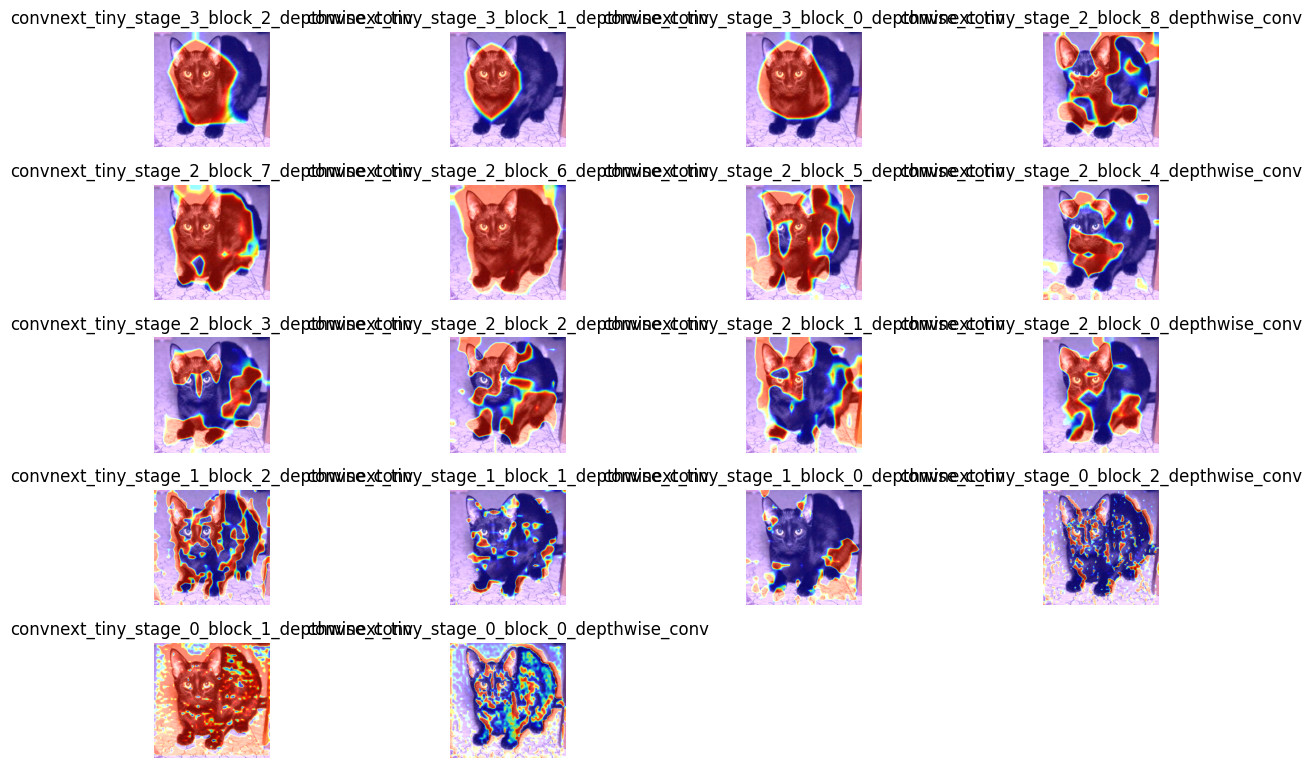

In [ ]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


In [ ]:
def fuse_layers(layers, model, img, emphasize=False):
  '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap
    and superimposes the heatmap onto an image.

    Args:
      layers: list of strings
      model: tf model
      img: (img_width x img_height x 3) numpy array


    Returns
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

  return superimposed


# Investigating Model Errors with Grad-CAM


In [ ]:
y_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
preds = model.predict(X)
y_preds = []
for pred in preds:
  y_preds.append(decode_prediction(pred)[0])
y_preds = np.array(y_preds)

32/32 [==============================] - 1392s 43s/step


In [ ]:
## FNs
Idx_FN = np.squeeze(np.argwhere((y_preds == 0) & (y == 1)))
FNs = X[Idx_FN]
FN_files = files[Idx_FN]
FNs.shape


(500, 224, 224, 3)

In [ ]:
## FPs
Idx_FP = np.squeeze(np.argwhere((y_preds == 1) & (y == 0)))
FPs = X[Idx_FP]
FP_files = files[Idx_FP]
FPs.shape

(0, 224, 224, 3)

In [ ]:
## FPs
fp_sample = 7

plt.figure(figsize=(30, 5))
for i, img in enumerate(FPs[:fp_sample]):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  ax = plt.subplot(2, fp_sample, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title('Predicted: Dog')

for i, img in enumerate(FPs[:fp_sample]):
  fused = fuse_layers(all_layers, model, img, True)
  ax = plt.subplot( 2, fp_sample, i+fp_sample + 1)
  plt.imshow(fused)
  plt.axis('off')
  plt.title(str(i + 1))

plt.tight_layout()


<Figure size 3000x500 with 0 Axes>

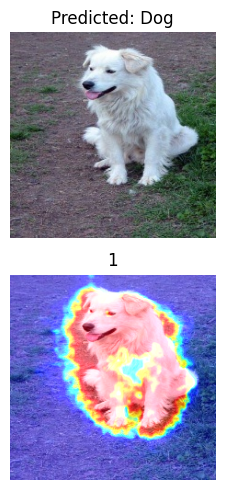

In [ ]:
## FNs
fn_sample = 1

plt.figure(figsize=(30, 5))
for i, img in enumerate(FNs[:fn_sample]):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  ax = plt.subplot(2, fn_sample, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title('Predicted: Dog')

for i, img in enumerate(FNs[:fn_sample]):
  fused = fuse_layers(all_layers, model, img, True)
  ax = plt.subplot( 2, fn_sample, i+fn_sample + 1)
  plt.imshow(fused)
  plt.axis('off')
  plt.title(str(i + 1))

plt.tight_layout()

In [ ]:
def predict_and_interpret(img_path, model, model_name, layers):
  '''
  Used for quick prediction and gradcam interpretation of external images not included
  in the original validation dataset. Primary use is to find cases the model has trouble
  with.
  '''
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))

  pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]
  pred = decode_prediction(pred_raw)
  pred_label = class_info[pred]
  fused = fuse_layers(layers, model, img)

  return img, fused, pred_raw

In [ ]:
def produce_course_semantic_segmentation(fused, img, thresh):
  '''
  Segments out red areas on a Grad-CAM heat-map based on a threshold.
  Then filters the original image based on the red area and returns the "masked"
  image.
  '''
  mask = np.where((fused[:, :, 0] == 255) & (fused[:, :, 1] < thresh) & (fused[:, :, 2] < thresh), 1.0, 0.0)
  mask = mask.astype(bool)
  masked_img = img.copy()
  masked_img[~mask] = 0
  return masked_img